### Import Libraries

In [13]:
import os
import pandas as pd
import requests
import re
from sqlalchemy import create_engine
from dotenv import load_dotenv
from bs4 import BeautifulSoup


# load the .env file variables

In [14]:
load_dotenv()

True

In [15]:
#create Web page 
url = "https://api.scrapingdog.com/scrape?api_key=657d00aef70c6975e9a97da0&url=https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue&dynamic=false"
response = requests.get(url)
print(response.status_code)

200


In [16]:
#tranform HTML
# If the request has been executed correctly (code 200), then the HTML content of the page has been downloaded
if response:
    # We transform the flat HTML into real HTML (structured and nested, tree-like)
    soup = BeautifulSoup(response.content, 'html.parser')
    soup

In [18]:
# Finding all table elements
tables = soup.find_all('table')

# Initialize an empty list to store the data
data = []

# Check if there are at least two tables
if len(tables) >= 2:
    # Selecting the second table
    second_table = tables[1]

    # Extracting data from the second table
    for row in second_table.find_all('tr'):
        columns = row.find_all('td')
        if len(columns) >= 2:
            date = columns[0].get_text().strip()
            revenue = columns[1].get_text().strip().replace('$', '').replace(',', '')
            data.append([date, revenue])

    # Creating a DataFrame
    df = pd.DataFrame(data, columns=['Date', 'Revenue'])

    # Output the DataFrame
    print(df)
else:
    print("There are not enough tables in the provided HTML content.")

          Date Revenue
0   2023-09-30   23350
1   2023-06-30   24927
2   2023-03-31   23329
3   2022-12-31   24318
4   2022-09-30   21454
5   2022-06-30   16934
6   2022-03-31   18756
7   2021-12-31   17719
8   2021-09-30   13757
9   2021-06-30   11958
10  2021-03-31   10389
11  2020-12-31   10744
12  2020-09-30    8771
13  2020-06-30    6036
14  2020-03-31    5985
15  2019-12-31    7384
16  2019-09-30    6303
17  2019-06-30    6350
18  2019-03-31    4541
19  2018-12-31    7226
20  2018-09-30    6824
21  2018-06-30    4002
22  2018-03-31    3409
23  2017-12-31    3288
24  2017-09-30    2985
25  2017-06-30    2790
26  2017-03-31    2696
27  2016-12-31    2285
28  2016-09-30    2298
29  2016-06-30    1270
30  2016-03-31    1147
31  2015-12-31    1214
32  2015-09-30     937
33  2015-06-30     955
34  2015-03-31     940
35  2014-12-31     957
36  2014-09-30     852
37  2014-06-30     769
38  2014-03-31     621
39  2013-12-31     615
40  2013-09-30     431
41  2013-06-30     405
42  2013-03

In [19]:
df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce').fillna(0).astype(int)

In [20]:
df['Revenue'].dropna()
description = df['Revenue'].describe()
print(description)

count       58.000000
mean      5401.534483
std       7333.256626
min          0.000000
25%        330.750000
50%       1777.500000
75%       7125.500000
max      24927.000000
Name: Revenue, dtype: float64


In [21]:
print(df.tail(20))

          Date  Revenue
38  2014-03-31      621
39  2013-12-31      615
40  2013-09-30      431
41  2013-06-30      405
42  2013-03-31      562
43  2012-12-31      306
44  2012-09-30       50
45  2012-06-30       27
46  2012-03-31       30
47  2011-12-31       39
48  2011-09-30       58
49  2011-06-30       58
50  2011-03-31       49
51  2010-12-31       36
52  2010-09-30       31
53  2010-06-30       28
54  2010-03-31       21
55  2009-12-31        0
56  2009-09-30       46
57  2009-06-30       27


In [22]:
import pandas as pd

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and quarter and create a combined column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Year_Quarter'] = df['Year'].astype(str) + ' Q' + df['Quarter'].astype(str)

# Display the updated DataFrame
print(df[['Year_Quarter', 'Revenue']])

   Year_Quarter  Revenue
0       2023 Q3    23350
1       2023 Q2    24927
2       2023 Q1    23329
3       2022 Q4    24318
4       2022 Q3    21454
5       2022 Q2    16934
6       2022 Q1    18756
7       2021 Q4    17719
8       2021 Q3    13757
9       2021 Q2    11958
10      2021 Q1    10389
11      2020 Q4    10744
12      2020 Q3     8771
13      2020 Q2     6036
14      2020 Q1     5985
15      2019 Q4     7384
16      2019 Q3     6303
17      2019 Q2     6350
18      2019 Q1     4541
19      2018 Q4     7226
20      2018 Q3     6824
21      2018 Q2     4002
22      2018 Q1     3409
23      2017 Q4     3288
24      2017 Q3     2985
25      2017 Q2     2790
26      2017 Q1     2696
27      2016 Q4     2285
28      2016 Q3     2298
29      2016 Q2     1270
30      2016 Q1     1147
31      2015 Q4     1214
32      2015 Q3      937
33      2015 Q2      955
34      2015 Q1      940
35      2014 Q4      957
36      2014 Q3      852
37      2014 Q2      769
38      2014 Q1      621


In [28]:
#Store the data in SQLite database 
# Connect to the SQLite database
import sqlite3


# Select only the 'Year_Quarter' and 'Revenue' columns
df_selected = df[['Year_Quarter', 'Revenue']]

# Connect to the SQLite database
conn = sqlite3.connect('tesla_qtr_data.db')

# Create a table
create_table_query = """
CREATE TABLE IF NOT EXISTS tesla_revenue (
    Year_Quarter TEXT NOT NULL,
    Revenue REAL
);
"""
conn.execute(create_table_query)

# Insert selected DataFrame contents into the database
df_selected.to_sql('tesla_revenue', conn, if_exists='replace', index=False)

# Function to print the contents of the table
def print_table_contents(connection):
    query = "SELECT * FROM tesla_revenue"
    for row in connection.execute(query):
        print(row)

# Print the table contents to verify
print("Contents of the table 'tesla_revenue':")
print_table_contents(conn)

# Close the connection
conn.close()

Contents of the table 'tesla_revenue':
('2023 Q3', 23350)
('2023 Q2', 24927)
('2023 Q1', 23329)
('2022 Q4', 24318)
('2022 Q3', 21454)
('2022 Q2', 16934)
('2022 Q1', 18756)
('2021 Q4', 17719)
('2021 Q3', 13757)
('2021 Q2', 11958)
('2021 Q1', 10389)
('2020 Q4', 10744)
('2020 Q3', 8771)
('2020 Q2', 6036)
('2020 Q1', 5985)
('2019 Q4', 7384)
('2019 Q3', 6303)
('2019 Q2', 6350)
('2019 Q1', 4541)
('2018 Q4', 7226)
('2018 Q3', 6824)
('2018 Q2', 4002)
('2018 Q1', 3409)
('2017 Q4', 3288)
('2017 Q3', 2985)
('2017 Q2', 2790)
('2017 Q1', 2696)
('2016 Q4', 2285)
('2016 Q3', 2298)
('2016 Q2', 1270)
('2016 Q1', 1147)
('2015 Q4', 1214)
('2015 Q3', 937)
('2015 Q2', 955)
('2015 Q1', 940)
('2014 Q4', 957)
('2014 Q3', 852)
('2014 Q2', 769)
('2014 Q1', 621)
('2013 Q4', 615)
('2013 Q3', 431)
('2013 Q2', 405)
('2013 Q1', 562)
('2012 Q4', 306)
('2012 Q3', 50)
('2012 Q2', 27)
('2012 Q1', 30)
('2011 Q4', 39)
('2011 Q3', 58)
('2011 Q2', 58)
('2011 Q1', 49)
('2010 Q4', 36)
('2010 Q3', 31)
('2010 Q2', 28)
('2010 Q1

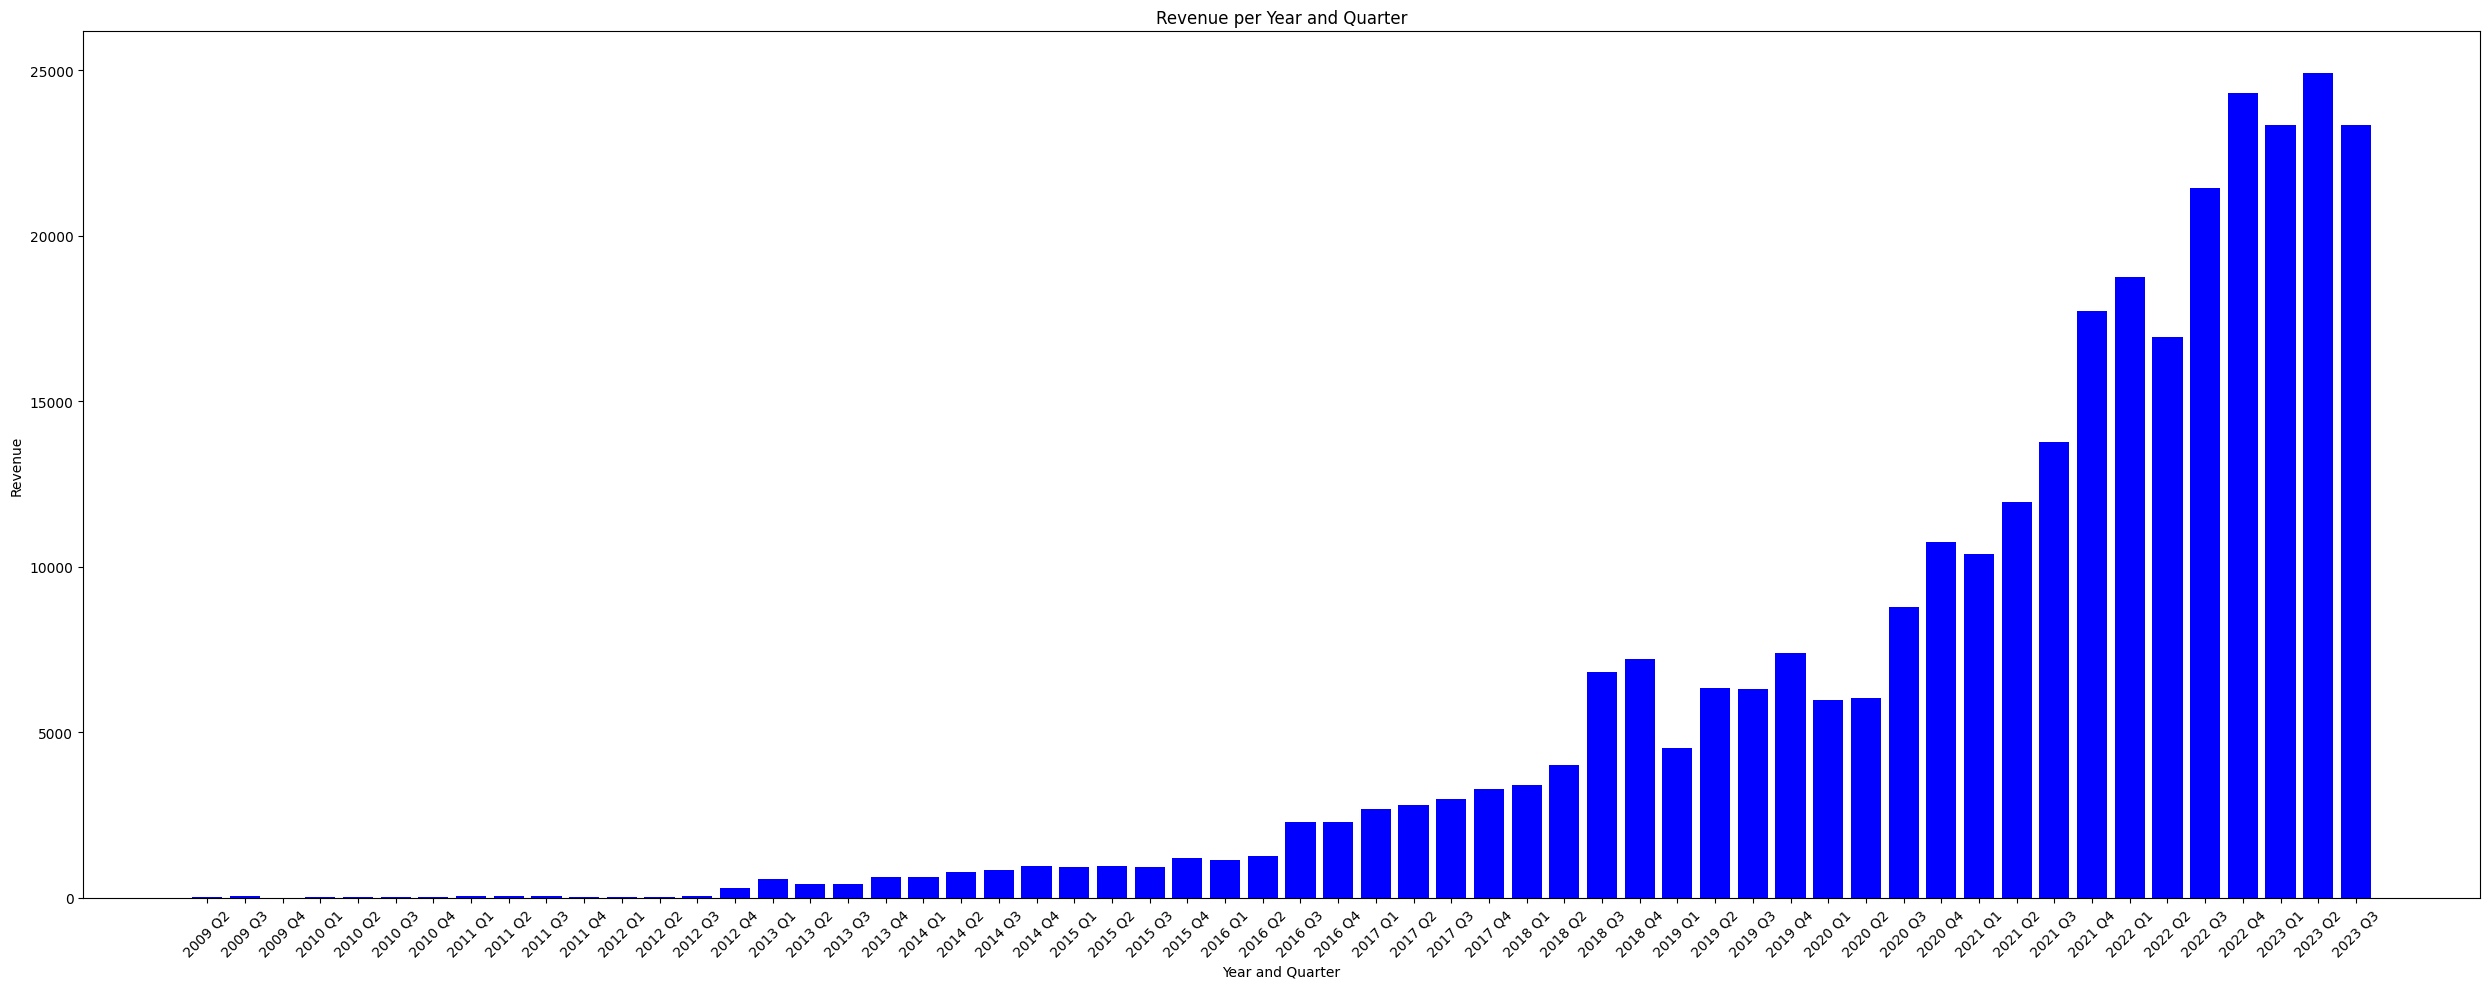

In [27]:
import matplotlib.pyplot as plt

# Ensure your DataFrame df has 'Year_Quarter' and 'Revenue' columns
#df = df

# Sort the DataFrame by 'Year_Quarter' column
df_sorted = df.sort_values(by='Year_Quarter')

# Creating the bar chart
plt.figure(figsize=(25,10))  # Optional: Adjusts the size of the chart
plt.bar(df_sorted['Year_Quarter'], df_sorted['Revenue'], color='blue')  # You can choose a color

# Adding title and labels
plt.title('Revenue per Year and Quarter')
plt.xlabel('Year and Quarter')
plt.ylabel('Revenue')

# Optionally, you can rotate the x-labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area
plt.show()


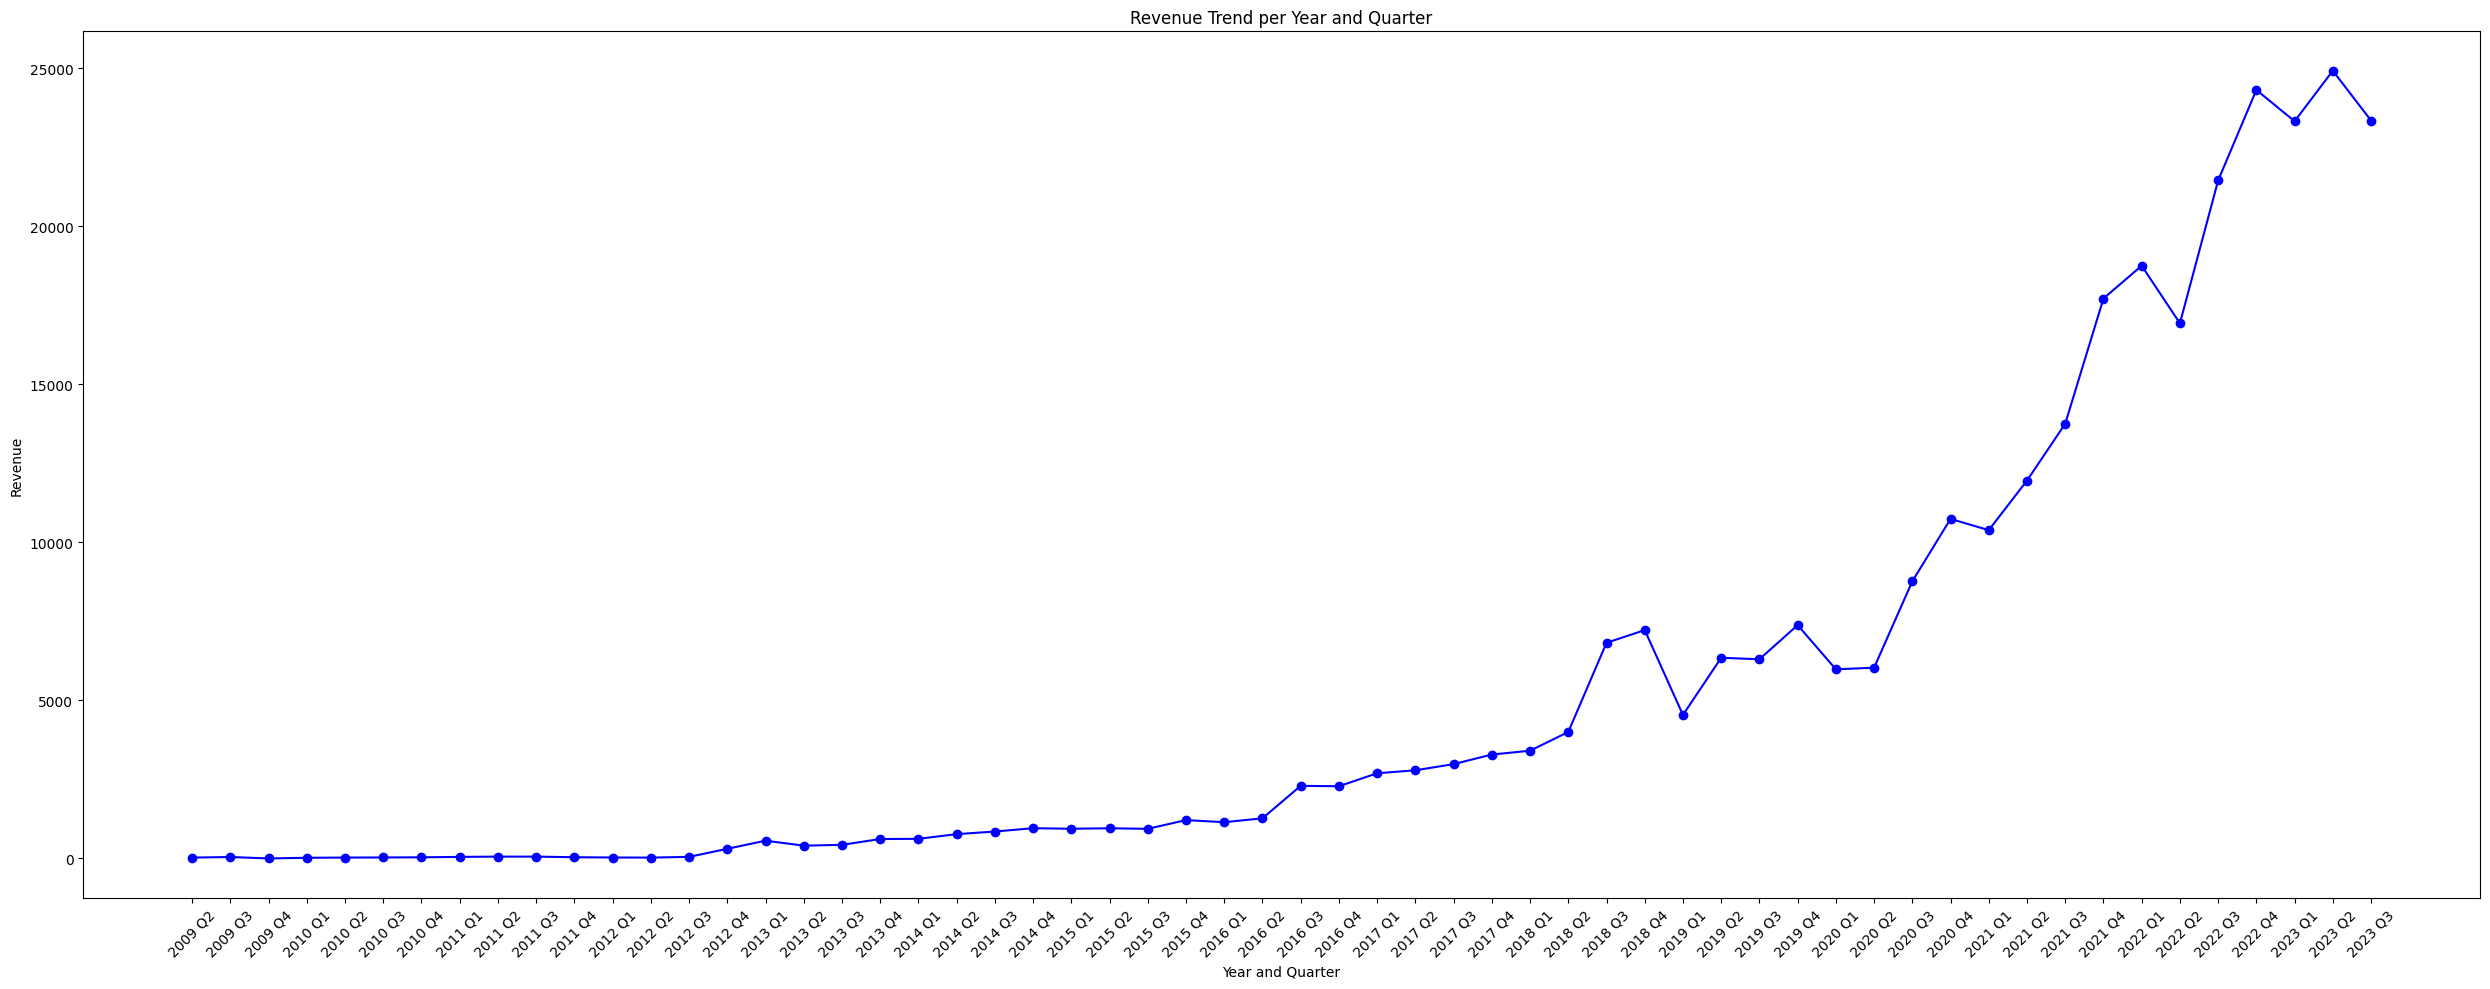

In [ ]:
# Assuming df is your DataFrame

# Sort the DataFrame by 'Year_Quarter' column
df_sorted = df.sort_values(by='Year_Quarter')

# Creating the line plot with the sorted DataFrame
plt.figure(figsize=(25,10))  # Adjusts the size of the chart
plt.plot(df_sorted['Year_Quarter'], df_sorted['Revenue'], marker='o', color='blue')  # Markers are optional

# Adding title and labels
plt.title('Revenue Trend per Year and Quarter')
plt.xlabel('Year and Quarter')
plt.ylabel('Revenue')

# Rotate the x-labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area
plt.show()


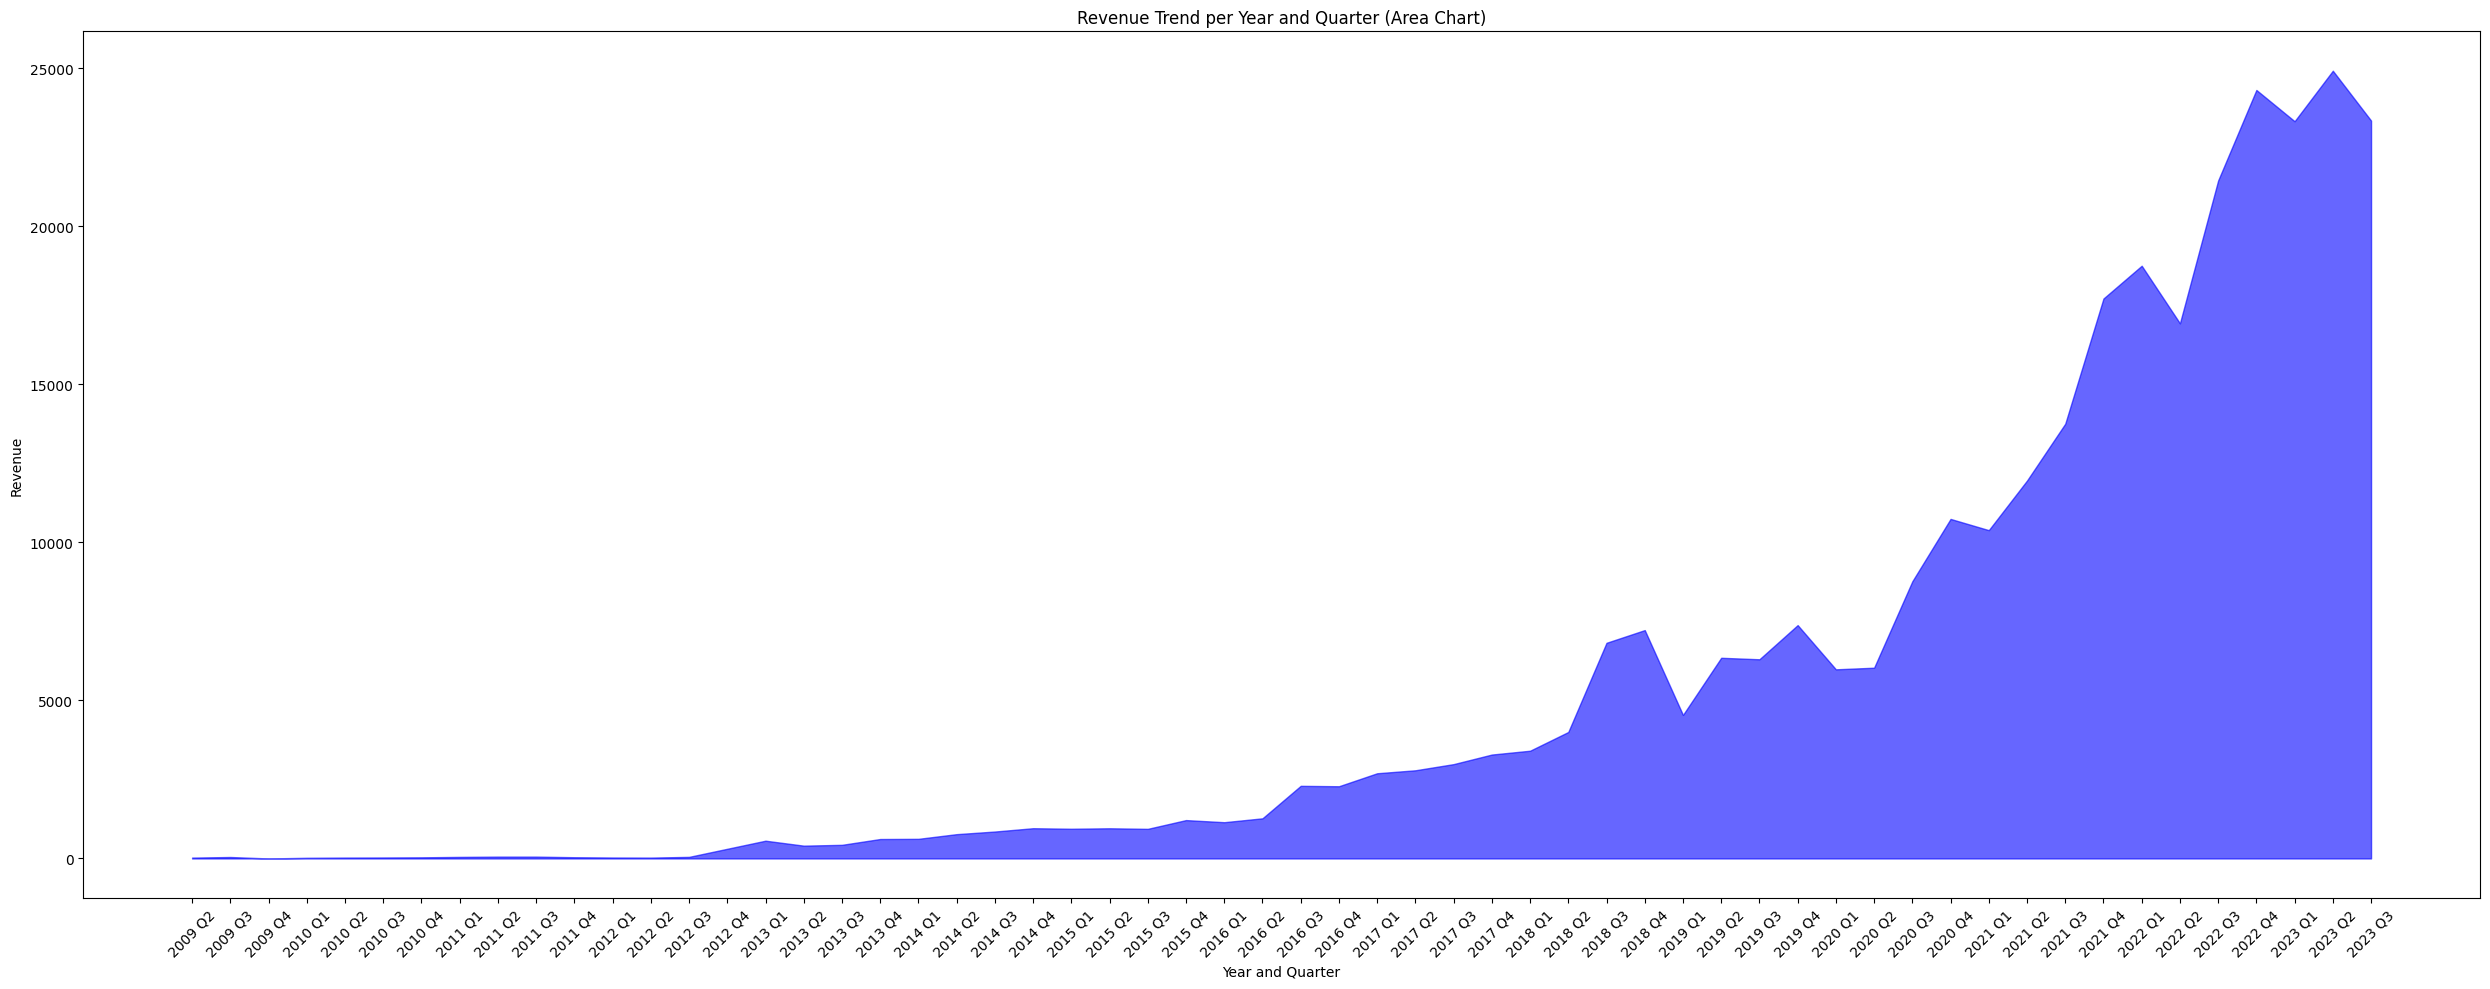

In [ ]:
# Sort the DataFrame by 'Year_Quarter' column
df_sorted = df.sort_values(by='Year_Quarter')

# Creating the area chart with the sorted DataFrame
plt.figure(figsize=(25,10))  # Adjusts the size of the chart
plt.fill_between(df_sorted['Year_Quarter'], df_sorted['Revenue'], color='blue', alpha=0.6)

# Adding title and labels
plt.title('Revenue Trend per Year and Quarter (Area Chart)')
plt.xlabel('Year and Quarter')
plt.ylabel('Revenue')

# Rotate the x-labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area
plt.show()
